In [208]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import copy

class LaneFinding():
    def __init__(self):
        self.ym_per_pix = 30/720
        self.xm_per_pix = 3.7/700
        self.obj_points , self.img_points = self.camera_calibrate()
        #self.src = np.float32([[744,484] , [1099 , 715] , [209 , 717],[545 , 484]])
        #self.src = np.float32([[702,456] , [1121 , 715] , [209 , 717],[588 , 456]])
        self.src = np.float32([[710,463] , [1111 , 715] , [209 , 717],[578 , 463]])

        
        #Binary Image Settings
        self.sx_thresh=(30, 100)
        self.s_thresh=(170, 255)
        
        
        # HYPERPARAMETERS
        self.nwindows = 9
        self.margin = 100
        self.minpix = 50
        self.line_base_pos = 0
        self.radius_of_curvature = 0
        
        #OTHERS
        self.undistort_img = None
        self.current_fit = None
        self.bestx = []
        
    def set_image_parameters(self,img):
        self.img = img
        self.img_size =  (img.shape[1], img.shape[0])
        #Perspective Transformation settings
        self._offset_leftright = 210
        self._offset_topbottom = 0
        self.dst = np.float32([[self.img_size[0]-self._offset_leftright, self._offset_topbottom],\
                               [self.img_size[0]-self._offset_leftright, self.img_size[1]-self._offset_topbottom],[self._offset_leftright, self.img_size[1]-self._offset_topbottom],\
                               [self._offset_leftright, self._offset_topbottom]])
        
    def camera_calibrate(self , nx = 9 , ny=6):
        obj_points = []
        img_points = []
        objp = np.zeros((nx * ny , 3) , np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        images = glob.glob('camera_cal/calibration*.jpg')
        for img_path in images:
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
            if ret == True:
                obj_points.append(objp)
                img_points.append(corners)
        return obj_points , img_points
        
    def undistort_image(self):
        copy_img = copy.deepcopy(self.img)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.obj_points, self.img_points, copy_img.shape[1::-1], None, None)
        dst = cv2.undistort(copy_img, mtx, dist, None, mtx)
        self.undistort_img = dst
        return dst
        
    def get_binary_image(self):
        hls = cv2.cvtColor(self.undistort_img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= self.sx_thresh[0]) & (scaled_sobel <= self.sx_thresh[1])] = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= self.s_thresh[0]) & (s_channel <= self.s_thresh[1])] = 255
        combined1 = np.bitwise_or(sxbinary,s_binary)
        
        hsv =  cv2.cvtColor(self.undistort_img, cv2.COLOR_RGB2HSV)
        l_w = np.array([0,0,180])
        u_w = np.array([135,20,255])
        white_mask = cv2.inRange(hsv, l_w,u_w)

        l_y = np.array([15,120,120])
        u_y = np.array([35,180,250])
        yellow_mask = cv2.inRange(hsv, l_y,u_y)

        image_mask = cv2.bitwise_or(yellow_mask, white_mask)
        
        combined = cv2.bitwise_or(combined1,image_mask)


        #kernel = np.ones((3,3), np.uint8) 
        #img_erosion = cv2.erode(combined, kernel, iterations=1) 

        
        return cv2.cvtColor(combined , cv2.COLOR_GRAY2RGB)
        
    def perspective_transform(self,img):
        M = cv2.getPerspectiveTransform(self.src, self.dst)
        wraped = cv2.warpPerspective(img, M, self.img_size , flags=cv2.INTER_LINEAR)
        self.ploty = np.linspace(0, wraped.shape[0]-1, wraped.shape[0] )
        return wraped
        
    def inverseTransform(self):
        Minv = cv2.getPerspectiveTransform(self.dst , self.src)
        return Minv
        
        
    def find_lane_pixels(self , binary_warped):
        binary_warped2 = cv2.cvtColor(binary_warped , cv2.COLOR_RGB2GRAY)
        histogram = np.sum(binary_warped2[binary_warped2.shape[0]//2:,:], axis=0)
        out_img = copy.deepcopy(binary_warped)
       
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        #self.line_base_pos = round((midpoint  - ((leftx_base + rightx_base) / 2 ) ) * self.xm_per_pix , 2)
        
        window_height = np.int(binary_warped2.shape[0]//self.nwindows)
        nonzero = binary_warped2.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - self.margin  # Update this
            win_xleft_high = leftx_current + self.margin  # Update this
            win_xright_low =  rightx_current - self.margin # Update this
            win_xright_high = rightx_current + self.margin   # Update this
            # Draw the windows on the visualization image
            #print(win_xleft_low,win_y_low , win_xleft_high,win_y_high)
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

            # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        return leftx, lefty, rightx, righty, out_img

    def get_average_fit(self,left_x,right_x):
        noofsamples = 20
        #print('n_array' ,left_x)
        if (len(self.bestx) == 0):
            self.bestx.append([left_x , right_x])
            w_x = [left_x , right_x]
            return w_x
        else:
            self.bestx = self.bestx[-1 * noofsamples:]
            #print(previousxypoints)
            #n_array = np.array(previousxypoints)
            bestx = np.array(self.bestx)
            best_left = np.mean(bestx[:,0],axis=0)
            best_right = np.mean(bestx[:,1],axis = 0)
            self.bestx.append([left_x , right_x])
            return [best_left , best_right]
            #left_list =  np.mean(n_array[:,0],axis=0,dtype=np.int32).tolist()
            #right_list = np.mean(n_array[:,1],axis=0,dtype=np.int32).tolist()
            #return [left_list , right_list]
        
    def fit_polynomial(self , binary_warped):
        if (self.current_fit == None):
            leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)
        else:
            leftx, lefty, rightx, righty, out_img = self.search_around_poly(binary_warped)
            
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        midpoint = np.int(self.img_size[0] //2)
        self.line_base_pos = round((midpoint  - ((np.mean(leftx) + np.mean(rightx)) / 2 ) ) * self.xm_per_pix , 2)

        # Generate x and y values for plotting
        #self.measure_curvature_pixels(lefty , leftx ,righty,rightx)
        try:
            left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
            right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
            self.current_fit = [left_fit , right_fit]
            
            bestxfit = self.get_average_fit(left_fit , right_fit)
            left_fit = .5 * left_fit + .5 * bestxfit[0]
            right_fit = .6 * right_fit + .4 * bestxfit[1]
            
            left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
            right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
            
            
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            self.current_fit = None
            left_fitx = 1*self.ploty**2 + 1*self.ploty
            right_fitx = 1*self.ploty**2 + 1*self.ploty
            
        self.measure_curvature_pixels(self.ploty , left_fit ,self.ploty,right_fit)

        ## Visualization ##
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        # DRAW--------------------
        left_p = np.int32(np.dstack((left_fitx , self.ploty)).reshape(-1,1,2))
        right_p = np.int32(np.dstack((right_fitx , self.ploty)).reshape(-1,1,2))
        out_img = cv2.polylines(out_img,[left_p],False,(255,255,0),thickness=15,lineType=cv2.LINE_AA)
        out_img = cv2.polylines(out_img,[right_p],False,(255,255,0),thickness=15,lineType=cv2.LINE_AA)

        return out_img , left_fitx  , right_fitx

    def measure_curvature_pixels(self,lefty, leftx_fit , righty , rightx_fit):
        # Real Space
        #left_fit_r = np.polyfit(lefty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
        #right_fit_r = np.polyfit(righty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
        y_eval = np.max(self.ploty)
        left_curverad = ((1 + (2*leftx_fit[0]*y_eval*self.ym_per_pix + leftx_fit[1])**2)**1.5) / np.absolute(2*leftx_fit[0])  ## Implement the calculation of the left line here
        right_curverad = ((1 + (2*rightx_fit[0]*y_eval*self.ym_per_pix + rightx_fit[1])**2)**1.5) / np.absolute(2*rightx_fit[0])  ## Implement the calculation of the right line here
        self.radius_of_curvature = round(np.mean([ left_curverad , right_curverad]) ,2)
        
    def fill_final_frame(self , warped , left_fitx , right_fitx,Minv,undist_img):
        # Create an image to draw the lines on
        color_warp = copy.deepcopy(warped)
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, self.img_size) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result,'Radius Of Curvature = ' + str(self.radius_of_curvature) + '(m)' ,(64,100), font, 1 ,(255,255,255),3,cv2.LINE_AA)
        #print('Calib offset = ' , calib_offset)
        if (self.line_base_pos > 0):
            pos = 'left'
        else:
            pos = 'right'
        
        cv2.putText(result,'Vehicle is ' + str(abs(self.line_base_pos)) + 'm '+pos +' of center'  ,(64,200), font, 1,(255,255,255),3,cv2.LINE_AA)

        return result

    
    def search_around_poly(self , binary_warped):
        # HYPERPARAMETER
        #print('in search around poly')
        margin = 50
        out_img = copy.deepcopy(binary_warped)
        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_fit = self.current_fit[0]
        right_fit = self.current_fit[1]

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1]*(nonzeroy) +
        left_fit[2] - margin)) & ( nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1]*(nonzeroy) +
        left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1]*(nonzeroy) +
        right_fit[2] - margin)) & ( nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1]*(nonzeroy) +
        right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        return leftx, lefty, rightx, righty, out_img

        

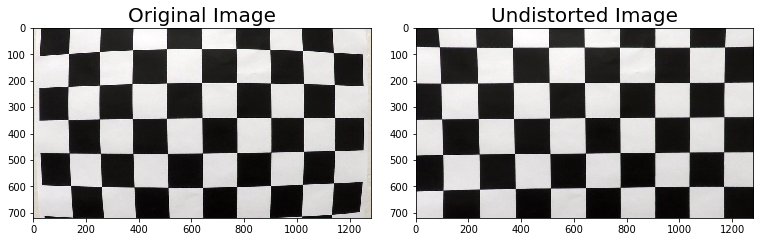

In [253]:
%matplotlib inline

# ---------------------------  CAMERA CALIBRATION -------------------------------
obj_class = LaneFinding()
obj_class.current_fit = None
img = mpimg.imread('camera_cal/calibration1.jpg')
obj_class.set_image_parameters(img)
undist_img = obj_class.undistort_image()
#plt.imshow(undist_img)
#saving undistorted image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/originalAndUndistored_calibration.png',bbox_inches="tight")

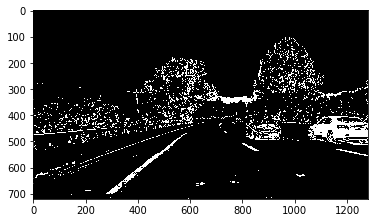

In [217]:

filename = 'test4.jpg'
img_cpy = mpimg.imread('test_images/'+filename)
obj_class = LaneFinding()
obj_class.current_fit = None
obj_class.set_image_parameters(img_cpy)
undist_img = obj_class.undistort_image()
#plt.imshow(undist_img)
#plt.savefig('output_images/image_undistorted.png')

simg = obj_class.get_binary_image()
plt.imshow(simg)
plt.savefig('output_images/image_binary.png')



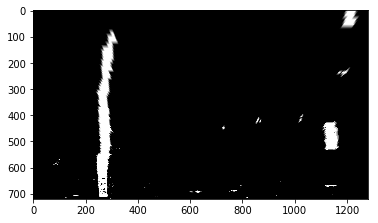

In [218]:
wraped  = obj_class.perspective_transform(simg)
plt.imshow(wraped)
plt.savefig('output_images/image_bird_eye_view.png')

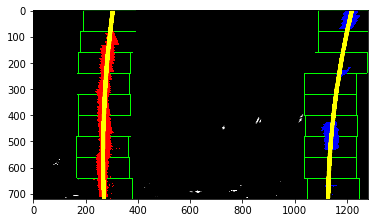

In [219]:
polynomial_curve , left , right = obj_class.fit_polynomial(wraped)
plt.imshow(polynomial_curve)
plt.savefig('output_images/image_polyfit.png')

In [220]:
print('Center= ', obj_class.line_base_pos  , '| Radius Of Curvature = ',obj_class.radius_of_curvature)
Minv = obj_class.inverseTransform()

Center=  -0.43 | Radius Of Curvature =  3852.99


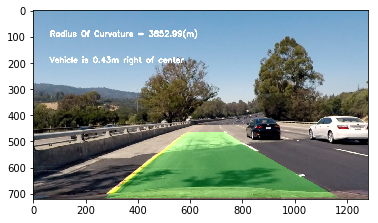

In [221]:
result = obj_class.fill_final_frame(wraped , left, right,Minv,undist_img)
plt.imshow(result)
plt.savefig('output_images/image_final_result.png')

In [11]:

def process_image(img):
    obj_class2.set_image_parameters(img)
    undist_img = obj_class2.undistort_image()
    #obj_class.current_fit = None

    #plt.imshow(undist_img)
    simg = obj_class2.get_binary_image()
    #plt.imshow(simg)
    wraped  = obj_class2.perspective_transform(simg)
    #plt.imshow(wraped)
    polynomial_curve , left , right = obj_class2.fit_polynomial(wraped)
    #print('Center= ', obj_class.line_base_pos  , '| Radius Of Curvature = ',obj_class.radius_of_curvature)
    
    Minv = obj_class2.inverseTransform()
    result = obj_class2.fill_final_frame(wraped , left, right,Minv,undist_img)
    
    return result
    #plt.imshow(polynomial_curve)
    

In [107]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [211]:
obj_class2 = LaneFinding()
obj_class2.current_fit = None
obj_class2.bestx = []
#output_video = 'output_videos/test_polysearch_tr2.mp4'
output_video = 'output_videos/output1.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("output_videos/clip2.mp4")
w_clip = clip1.fl_image(process_image)
%time w_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_videos/output1.mp4
[MoviePy] Writing video output_videos/output1.mp4


100%|█████████▉| 1260/1261 [13:31<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output1.mp4 

CPU times: user 11min 14s, sys: 4.15 s, total: 11min 18s
Wall time: 13min 34s
